In [1]:
#import math
import datasets
import debug_helpers
#import datetime

#import collections
#import aer
#import warnings
#import numpy as np

import persistence
import plots
import convergence_criterion as cc
#import random

import initializations as inits
import IBM2 as ibm2


# pretty print variabeles on line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
s_t_pairs, _, _ = datasets.example_data_word_order()

lprobs_random = inits.initialize_lprobs_randomly(s_t_pairs)
jump_probs_random = inits.initialize_jump_probs_randomly(s_t_pairs)

(lprobs, jump_probs, _, _) = ibm2.EM(
    s_t_pairs, 
    lprobs_random, 
    jump_probs_random, 
    30
) 

s_t_pairs
debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs



[(['<NULL>', 'Haus', 'das'], ['the', 'house']),
 (['<NULL>', 'Buch', 'das'], ['the', 'book']),
 (['<NULL>', 'Buch', 'ein'], ['a', 'book']),
 (['<NULL>', 'Maus', 'ein'], ['a', 'mouse']),
 (['<NULL>', 'Hund', 'das'], ['the', 'dog']),
 (['<NULL>', 'Welt', 'ein'], ['a', 'world']),
 (['<NULL>', 'Boot', 'das'], ['the', 'boat']),
 (['<NULL>', 'Brugge', 'ein'], ['a', 'bridge'])]

<NULL> the 0.5319694503562006
<NULL> house 7.987458803396552e-20
<NULL> book 1.1466648212934342e-10
<NULL> a 0.46803054952913314
<NULL> mouse 5.113201381321028e-20
<NULL> dog 1.6494181725310438e-19
<NULL> world 2.4363828579385286e-19
<NULL> boat 9.076420473656312e-19
<NULL> bridge 5.1785139642635116e-21
Haus house 1.0
das the 1.0
Buch book 1.0
ein a 1.0
Maus mouse 1.0
Hund dog 1.0
Welt world 1.0
Boot boat 1.0
Brugge bridge 1.0



[0.5, 0.0, 0.49999999969047393, 3.0952606539520375e-10]

In [4]:
def fname_ibm2(fname):
    return f'IBM2_output/{fname}.txt'

# HACK: store converged models during the iteration run
converged_models = []
def save_selected_models(i, llhood, AER, prev_llhood, prev_AER,
                      lprobs, jump_probs, mname):
    debug_helpers.print_likelihood(i, [], llhood, AER)
    if prev_AER and (f'{mname}_AER' not in converged_models) and cc.has_converged_AER(prev_AER, AER):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_AER_{i}'))
        converged_models.append(f'{mname}_AER')
    if prev_llhood and (f'{mname}_LL' not in converged_models) and cc.has_converged_LLhood(prev_llhood, llhood):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_llhood_{i}'))
        converged_models.append(f'{mname}_LL')
        
def run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    fn_init, fn_init_jumps, init_name):

    lprobs_init = fn_init(s_t_pairs)
    jump_probs_init = fn_init_jumps(s_t_pairs)

    # EM
    (lprobs, jump_probs, llhoods, AERs) = ibm2.EM (
        s_t_pairs, 
        lprobs_init, 
        jump_probs_init,
        15,
        val_sentence_pairs, reference_alignments, 
        save_selected_models, init_name)

    # store AER and llhood scores in file
    persistence.save(AERs, fname_ibm2(f'AERs_{init_name}'))
    persistence.save(llhoods, fname_ibm2(f'llhoods_{init_name}'))

    # select models based on AER and llhood selection criterion
    selected_model_AER = fname_ibm2(cc.select_model_AER(AERs))
    selected_model_llhood = fname_ibm2(cc.select_model_LLhood(llhoods))
    print(f'model selected on AER for {init_name}:', selected_model_AER)
    print(f'model selected on LLhood for {init_name}:', selected_model_llhood)

    # plot AER and llhood scores vs iteration
    plots.figure_log_likelihood(llhoods, f'IBM2_{init_name}')
    plots.figure_AER(AERs, f'IBM2_{init_name}')

iteration    log_likelihood    AER    time
0 -29.323 0.00000 11:24
1 -17.916 0.00000 11:24
2 -12.742 0.00000 11:24
3 -6.095 0.00000 11:24
4 -1.882 0.00000 11:24
5 -0.709 0.00000 11:24
6 -0.342 0.00000 11:24
7 -0.169 0.00000 11:24
8 -0.084 0.00000 11:24
9 -0.042 0.00000 11:24
10 -0.021 0.00000 11:24
11 -0.010 0.00000 11:24
12 -0.005 0.00000 11:24
13 -0.003 0.00000 11:24
14 -0.001 0.00000 11:24
model selected on AER for IBM2_RR_1: IBM2_output/None.txt
model selected on LLhood for IBM2_RR_1: IBM2_output/None.txt


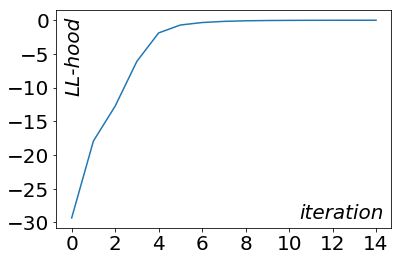

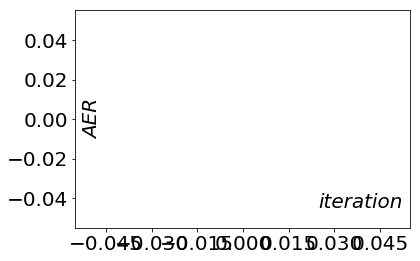

iteration    log_likelihood    AER    time
0 -27.064 0.00000 11:24
1 -12.051 0.00000 11:24
2 -7.090 0.00000 11:24
3 -4.551 0.00000 11:24
4 -2.825 0.00000 11:24
5 -1.627 0.00000 11:24
6 -0.884 0.00000 11:24
7 -0.462 0.00000 11:24
8 -0.237 0.00000 11:24
9 -0.120 0.00000 11:24
10 -0.060 0.00000 11:24
11 -0.030 0.00000 11:24
12 -0.015 0.00000 11:24
13 -0.008 0.00000 11:24
14 -0.004 0.00000 11:24
model selected on AER for IBM2_RR_2: IBM2_output/None.txt
model selected on LLhood for IBM2_RR_2: IBM2_output/None.txt


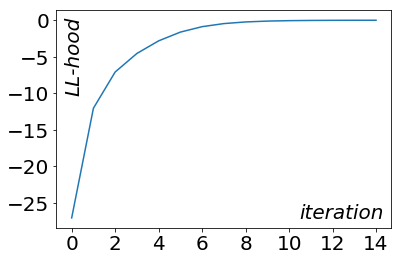

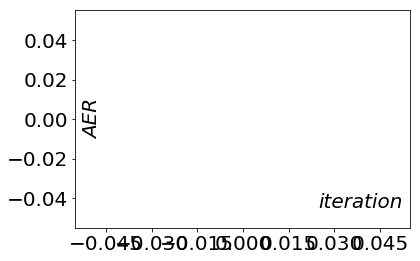

iteration    log_likelihood    AER    time
0 -26.153 0.00000 11:24
1 -20.803 0.00000 11:24
2 -18.413 0.00000 11:24
3 -14.913 0.00000 11:24
4 -12.950 0.00000 11:24
5 -12.598 0.00000 11:24
6 -12.529 0.00000 11:24
7 -12.501 0.00000 11:24
8 -12.488 0.00000 11:24
9 -12.482 0.00000 11:24
10 -12.479 0.00000 11:24
11 -12.478 0.00000 11:24
12 -12.477 0.00000 11:24
13 -12.477 0.00000 11:24
14 -12.477 0.00000 11:24
model selected on AER for IBM2_RR_3: IBM2_output/None.txt
model selected on LLhood for IBM2_RR_3: IBM2_output/9.txt


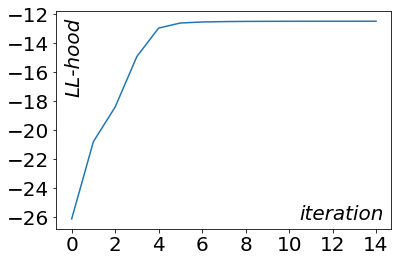

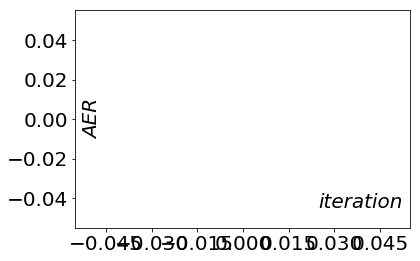

iteration    log_likelihood    AER    time
0 -21.847 0.00000 11:24
1 -18.498 0.00000 11:24
2 -17.347 0.00000 11:24
3 -16.878 0.00000 11:24
4 -16.722 0.00000 11:24
5 -16.703 0.00000 11:24
6 -16.755 0.00000 11:24
7 -16.840 0.00000 11:24
8 -16.855 0.00000 11:24
9 -16.560 0.00000 11:24
10 -15.919 0.00000 11:24
11 -15.379 0.00000 11:24
12 -14.696 0.00000 11:24
13 -13.649 0.00000 11:24
14 -12.759 0.00000 11:24
model selected on AER for IBM2_uniform: IBM2_output/None.txt
model selected on LLhood for IBM2_uniform: IBM2_output/8.txt


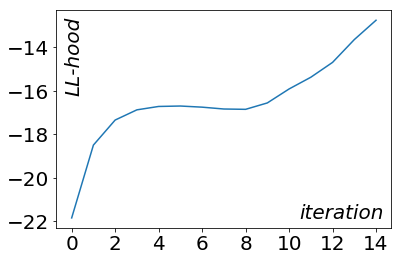

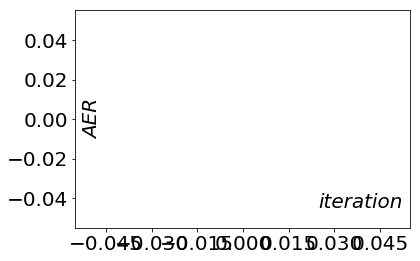

In [5]:
# s_t_pairs, s_vocabulary, t_vocabulary = datasets.training_data()
# val_sentence_pairs = datasets.validation_data(s_vocabulary, t_vocabulary)
# reference_alignments = datasets.validation_alignments()    

s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_word_order()
val_sentence_pairs = None
reference_alignments = None    

converged_models = []

# Run EM on training data set with AER on validation set
# using random initialization (3x)
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_1')
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_2')
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_3')

# Run EM on training data set with AER on validation set
# using uniform initialization 
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_uniform, inits.initialize_jump_probs_uniformly, 'IBM2_uniform')

# Run EM on training data set with AER on validation set
# using initialization with IBM 1 und uniform jump probabilities
# run_em_with_initialization(
#     s_t_pairs, val_sentence_pairs, reference_alignments,
#     inits.initialize_lprobs_staged, inits.initialize_jump_probs_uniformly, 'IBM2_staged')





In [ ]:
converged_models


In [ ]:
AER_lines = []
llhood_lines = []
model_names = []
for i in [1,2,3]:
    init_name = f'IBM2_rr_{i}'
    fname_ibm2_AERs = f'ibm2_AERs_{init_name}.txt'    
    fname_ibm2_llhoods = f'ibm2_llhoods_{init_name}.txt'
    AERs = persistence.load(fname_ibm2_AERs)
    llhoods = persistence.load(fname_ibm2_llhoods)
    AER_lines.append(AERs)
    llhood_lines.append(llhoods)
    model_names.append(f'random_{i}') 

In [ ]:
AER_lines.append(persistence.load('ibm2_AERs_iter15.txt'))
llhood_lines.append(persistence.load('ibm2_llhoods_iter15.txt'))
model_names.append(r'uniform')

In [ ]:
figure_AER_multiple_lines(AER_lines, model_names, 'IBM2_inits')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator


In [ ]:
figure_llhood_multiple_lines(llhood_lines, model_names, 'IBM2_inits')

In [ ]:
llhood_lines